In [56]:
# util
import pandas as pd
import re

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Load Data

In [57]:
%%time

files = "twitter_sentiment.csv" 
col_names = ["target", "id", "date", "flag", "user", "text"]
chunk = pd.read_csv(files, chunksize=100000, encoding='ISO-8859-1', names=col_names)
concat_df = pd.concat(chunk)

Wall time: 5.7 s


In [58]:
df = concat_df.drop(columns=["id", "date", "flag", "user"]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df.shape)
df.head()

(1600000, 2)


,target,text
0,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,"@misstoriblack cool , i have no tweet apps fo..."
2,0,@TiannaChaos i know just family drama. its la...
3,0,School email won't open and I have geography ...
4,0,upper airways problem


In [59]:
%%time
sentiment_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return sentiment_map[int(label)]

df.target = df.target.apply(lambda x: decode_sentiment(x))
df.head()

Wall time: 680 ms


,target,text
0,NEGATIVE,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,NEGATIVE,"@misstoriblack cool , i have no tweet apps fo..."
2,NEGATIVE,@TiannaChaos i know just family drama. its la...
3,NEGATIVE,School email won't open and I have geography ...
4,NEGATIVE,upper airways problem


Text(0.5, 1.0, 'Distribution of data')

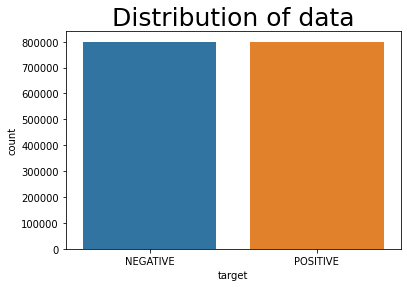

In [60]:
sns.countplot(x="target", data=df)
plt.title("Distribution of data", fontsize=25)

## Text Cleaning

In [61]:
%%time
%%capture

def text_cleaning(text):
    stop_words = stopwords.words('english')
    lemma = WordNetLemmatizer()
    
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    text = text.lower()
    text = re.sub(urlPattern, ' ', text)
    text = re.sub(userPattern, ' ', text)
    text = re.sub(alphaPattern, " ", text)
    text = re.sub(sequencePattern, seqReplacePattern, text)
    for emoji in emojis.keys():
        text = text.replace(emoji, "EMOJI" + emojis[emoji])
    if len(text) > 1:
        text = ' '.join([lemma.lemmatize(word) for word in word_tokenize(text) if word not in (stop_words)])
    text = text.strip()
    
    return text

df['cleaned_text'] = df['text'].apply(lambda x: text_cleaning(x))

Wall time: 19min 33s


In [62]:
df.head()

,target,text,cleaned_text
0,NEGATIVE,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahh hope ok
1,NEGATIVE,"@misstoriblack cool , i have no tweet apps fo...",cool tweet apps razr 2
2,NEGATIVE,@TiannaChaos i know just family drama. its la...,know family drama lame hey next time u hang ki...
3,NEGATIVE,School email won't open and I have geography ...,school email open geography stuff revise stupi...
4,NEGATIVE,upper airways problem,upper airway problem


In [63]:
df.isnull().sum()

target          0
text            0
cleaned_text    0
dtype: int64

## POSITIVE

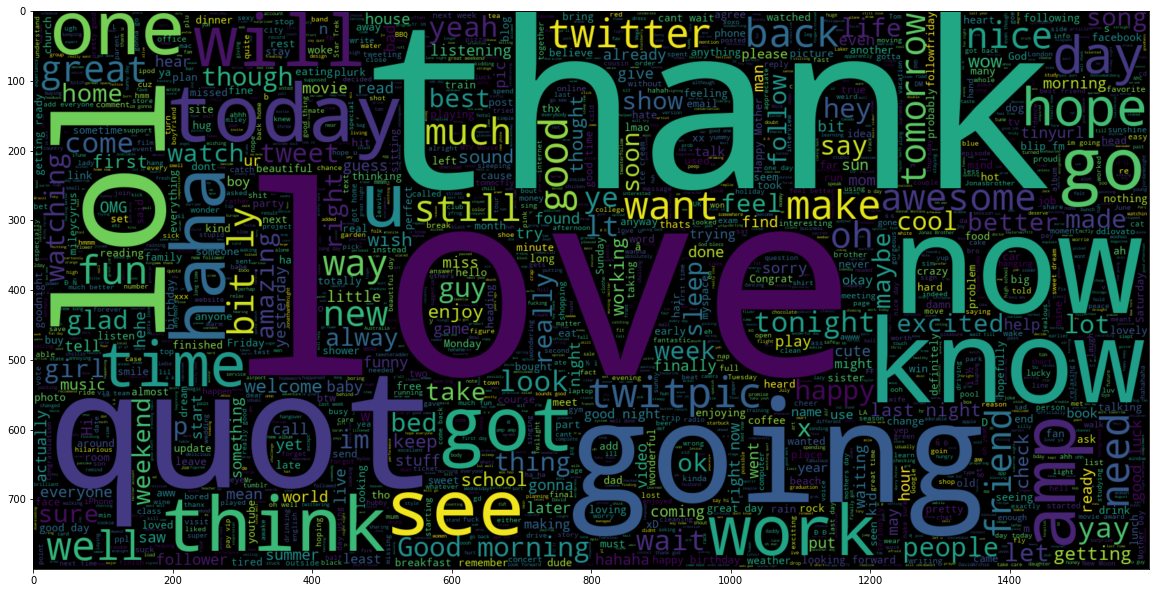

In [64]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 'POSITIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

## NEGATIVE

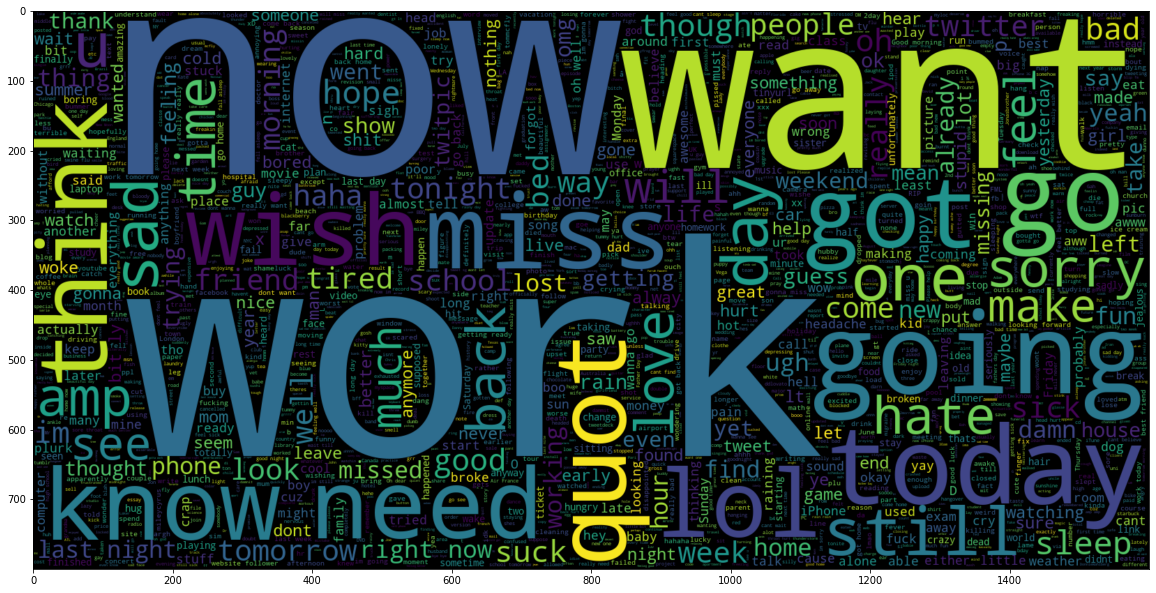

In [65]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 'NEGATIVE'].text))
plt.imshow(wc , interpolation = 'bilinear')

## EXPORT CLEAN CSV

In [68]:
df.to_csv('clean_twitter_sentimen.csv', index=False)